In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Library

In [ ]:
!pip install geopandas
!pip install mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.6 MB/s 
     |████████████████████████████████| 6.3 MB 8.7 MB/s 
     |████████████████████████████████| 16.7 MB 26.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt

# Data Cleaning

## Criminal Records Dataset

In [ ]:
# read crime dataset
data = pd.read_excel('/content/drive/MyDrive/FIT5120 Team TA25 \
                      Project Governance Portfolio/System Architecture \
                      and Security/Data Governance/Open Dataset/\
                      Data_Tables_LGA_Criminal_Incidents_Year_Ending_March_2022.xlsx', \
                      sheet_name='Table 03')

In [ ]:
# review the dataset
print("Dataset dimension: ", data.shape)
data.head()

Dataset dimension:  (326922, 9)


,Year,Year ending,Local Government Area,Postcode,Suburb/Town Name,Offence Division,Offence Subdivision,Offence Subgroup,Incidents Recorded
0,2022,March,Alpine,3691,Dederang,A Crimes against the person,Other crimes against the person,Other crimes against the person,2
1,2022,March,Alpine,3691,Dederang,B Property and deception offences,B30 Burglary/Break and enter,B321 Residential non-aggravated burglary,1
2,2022,March,Alpine,3691,Dederang,B Property and deception offences,B50 Deception,B53 Obtain benefit by deception,1
3,2022,March,Alpine,3691,Dederang,D Public order and security offences,D20 Disorderly and offensive conduct,D22 Drunk and disorderly in public,1
4,2022,March,Alpine,3691,Kergunyah South,E Justice procedures offences,E10 Justice procedures,E14 Pervert the course of justice or commit pe...,1


### Check data

In [ ]:
# check for the missing data
data.isnull().any()

Year                     False
Year ending              False
Local Government Area    False
Postcode                 False
Suburb/Town Name         False
Offence Division         False
Offence Subdivision      False
Offence Subgroup         False
Incidents Recorded       False
dtype: bool

In [ ]:
# check for duplicated data in the dataset
data.duplicated().any()

False

### Make Modification to the Data

In [ ]:
# get the value of the offence division in the data
data['Offence Division'].unique()

array(['A Crimes against the person', 'B Property and deception offences',
       'D Public order and security offences',
       'E Justice procedures offences', 'C Drug offences',
       'F Other offences'], dtype=object)

In [ ]:
# Remove first 2 character (sub title)
data['Offence Division'] = data['Offence Division'].str[2:]
data['Offence Division'].unique()

array(['Crimes against the person', 'Property and deception offences',
       'Public order and security offences',
       'Justice procedures offences', 'Drug offences', 'Other offences'],
      dtype=object)

In [ ]:
# filter the data to crime against the person only
against_person_data = data[data['Offence Division'] == 'Crimes against the person']
against_person_data.head()

,Year,Year ending,Local Government Area,Postcode,Suburb/Town Name,Offence Division,Offence Subdivision,Offence Subgroup,Incidents Recorded
0,2022,March,Alpine,3691,Dederang,Crimes against the person,Other crimes against the person,Other crimes against the person,2
14,2022,March,Alpine,3699,Mount Beauty,Crimes against the person,A20 Assault and related offences,A232 Non-FV Common assault,4
15,2022,March,Alpine,3699,Mount Beauty,Crimes against the person,A80 Dangerous and negligent acts endangering p...,A89 Other dangerous or negligent acts endanger...,1
23,2022,March,Alpine,3737,Barwidgee,Crimes against the person,A20 Assault and related offences,A211 FV Serious assault,2
24,2022,March,Alpine,3737,Barwidgee,Crimes against the person,A20 Assault and related offences,A231 FV Common assault,1


In [ ]:
# check the value of the crime subdivision
against_person_data['Offence Subdivision'].unique()

array(['Other crimes against the person',
       'A20 Assault and related offences',
       'A80 Dangerous and negligent acts endangering people',
       'A70 Stalking, harassment and threatening behaviour',
       'A50 Robbery'], dtype=object)

In [ ]:
# remove the sub-heading of the subdivision criteria
against_person_data.loc[against_person_data['Offence Subdivision'] != 'Other crimes against the person', 'Offence Subdivision'] = \
    against_person_data.loc[against_person_data['Offence Subdivision'] != 'Other crimes against the person', 'Offence Subdivision'].str[4:]
against_person_data['Offence Subdivision'].unique()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


array(['Other crimes against the person', 'Assault and related offences',
       'Dangerous and negligent acts endangering people',
       'Stalking, harassment and threatening behaviour', 'Robbery'],
      dtype=object)

In [ ]:
# drop the unecessary column
against_person_data = against_person_data.drop(['Offence Subgroup'], axis =1)

In [ ]:
# group by and sum the crime records
df_crime = against_person_data.groupby(['Year', 'Local Government Area', 'Suburb/Town Name', \
                                        'Postcode', 'Offence Subdivision'])['Incidents Recorded'].sum()
df_crime = df_crime.rename_axis(['Year', 'Local Government Area', 'Suburb/Town Name', \
                                 'Postcode', 'Offence Subdivision']).reset_index()
df_crime.head()

,Year,Local Government Area,Suburb/Town Name,Postcode,Offence Subdivision,Incidents Recorded
0,2013,Alpine,Bright,3741,Assault and related offences,5
1,2013,Alpine,Bright,3741,Other crimes against the person,5
2,2013,Alpine,Buffalo River,3737,Dangerous and negligent acts endangering people,1
3,2013,Alpine,Dederang,3691,Assault and related offences,1
4,2013,Alpine,Eurobin,3739,Dangerous and negligent acts endangering people,1


### Export Cleaned dataset

In [ ]:
# save Clean data to csv
df_crime.to_csv('/content/drive/MyDrive/FIT5120 Team TA25 Project Governance Portfolio/System Architecture and Security/Data Governance/Processed Data/clean_crime_1.csv')

## POSTCODE

In [ ]:
# read the postcode dataset
post = pd.read_csv('/content/drive/MyDrive/FIT5120 Team TA25 Project Governance Portfolio/System Architecture and Security/Data Governance/Open Dataset/au_postcodes.csv')
post.head()

,postcode,place_name,state_name,state_code,latitude,longitude,accuracy
0,200,Australian National University,Australian Capital Territory,ACT,-35.2777,149.1189,1.0
1,221,Barton,Australian Capital Territory,ACT,-35.3049,149.1412,4.0
2,2540,Wreck Bay,Australian Capital Territory,ACT,-35.1627,150.6907,4.0
3,2540,Hmas Creswell,Australian Capital Territory,ACT,-35.0280,150.5501,3.0
4,2540,Jervis Bay,Australian Capital Territory,ACT,-35.1333,150.7000,4.0


### Check Dataset

In [ ]:
# check for duplicated data in the dataset
post.duplicated().any()

False

In [ ]:
# check for the missing data in the dataset
post.isnull().any()

postcode      False
place_name    False
state_name    False
state_code    False
latitude      False
longitude     False
accuracy       True
dtype: bool

In [ ]:
# check for the records with the missing data
post[post['accuracy'].isnull()]

,postcode,place_name,state_name,state_code,latitude,longitude,accuracy
466,1900,Leightonfield Mc,New South Wales,NSW,-33.8816,150.9844,NaN
467,1902,Leightonfield Mc,New South Wales,NSW,-33.8816,150.9844,NaN
9094,9464,Northgate Mc,Queensland,QLD,-33.8816,150.9844,NaN
9095,9726,Gold Coast Mc,Queensland,QLD,-33.8816,150.9844,NaN


### Modify the dataset

In [ ]:
# filter to VIC state only
VIC_post = post[post['state_code'] == 'VIC']
VIC_post.head()

,postcode,place_name,state_name,state_code,latitude,longitude,accuracy
11712,3000,Melbourne,Victoria,VIC,-37.8140,144.9633,4.0
11713,3001,Melbourne,Victoria,VIC,-37.8140,144.9633,4.0
11714,3002,East Melbourne,Victoria,VIC,-37.8167,144.9879,4.0
11715,3003,West Melbourne,Victoria,VIC,-37.8101,144.9500,4.0
11716,3004,Melbourne,Victoria,VIC,-37.8140,144.9633,4.0


In [ ]:
# check for missing data in the filtered data
VIC_post.isnull().any()

postcode      False
place_name    False
state_name    False
state_code    False
latitude      False
longitude     False
accuracy      False
dtype: bool

In [ ]:
# remove unnecessary columns 
VIC_post = VIC_post.drop(['state_name', 'state_code', 'accuracy'], axis =1)
VIC_post.head()

,postcode,place_name,latitude,longitude
11712,3000,Melbourne,-37.8140,144.9633
11713,3001,Melbourne,-37.8140,144.9633
11714,3002,East Melbourne,-37.8167,144.9879
11715,3003,West Melbourne,-37.8101,144.9500
11716,3004,Melbourne,-37.8140,144.9633


### Export dataset

In [ ]:
# export clean dataset
VIC_post.to_csv('/content/drive/MyDrive/FIT5120 Team TA25 Project Governance Portfolio/System Architecture and Security/Data Governance/Processed Data/clean_postcode_1.csv')

## Suburb Boundary

In [ ]:
# read dataset
shapefile = gpd.read_file("/content/drive/MyDrive/FIT5120 Team TA25 Project Governance Portfolio/System Architecture and Security/Data Governance/Open Dataset/vic_localities.zip")
shapefile.head()

,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry
0,lcp6229215ba53f,locb0dcb52a6b55,2021-06-24,Abbeyard,Gazetted Locality,VIC,"POLYGON ((146.81721 -37.09735, 146.81729 -37.0..."
1,lcp386f2bcf9bce,locb9872f35df41,2021-06-24,Abbotsford,Gazetted Locality,VIC,"POLYGON ((145.00235 -37.80723, 145.00350 -37.8..."
2,lcp122c942a8fc9,loc8123ed12ea8d,2021-06-24,Aberfeldie,Gazetted Locality,VIC,"POLYGON ((144.89830 -37.76465, 144.89790 -37.7..."
3,lcp9f50bd795d16,loc1eb4a229104a,2021-06-24,Aberfeldy,Gazetted Locality,VIC,"POLYGON ((146.39447 -37.71008, 146.39405 -37.7..."
4,lcp59bf69caacb0,locb17be87767e1,2021-06-24,Acheron,Gazetted Locality,VIC,"POLYGON ((145.75030 -37.24313, 145.75036 -37.2..."


### Check Data

In [ ]:
# check missing data in the dataset
shapefile.isnull().any()

LC_PLY_PID    False
LOC_PID       False
DT_CREATE     False
LOC_NAME      False
LOC_CLASS     False
STATE         False
geometry      False
dtype: bool

In [ ]:
# check duplicated data in the dataset
shapefile.duplicated().any()

False

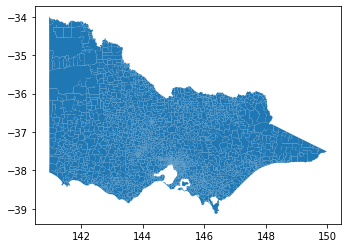

In [ ]:
shapefile.plot()

### Modify the dataset

In [ ]:
# drop unnecessary columns
shapefile = shapefile.drop(['LC_PLY_PID', 'LOC_PID', 'DT_CREATE', 'STATE'], axis =1)
shapefile.head()

,LOC_NAME,LOC_CLASS,geometry
0,Abbeyard,Gazetted Locality,"POLYGON ((146.81721 -37.09735, 146.81729 -37.0..."
1,Abbotsford,Gazetted Locality,"POLYGON ((145.00235 -37.80723, 145.00350 -37.8..."
2,Aberfeldie,Gazetted Locality,"POLYGON ((144.89830 -37.76465, 144.89790 -37.7..."
3,Aberfeldy,Gazetted Locality,"POLYGON ((146.39447 -37.71008, 146.39405 -37.7..."
4,Acheron,Gazetted Locality,"POLYGON ((145.75030 -37.24313, 145.75036 -37.2..."


### Export Dataset

In [ ]:
# Export Clean Dataset
shapefile.to_csv('/content/drive/MyDrive/FIT5120 Team TA25 Project Governance Portfolio/System Architecture and Security/Data Governance/Processed Data/clean_suburb_1.csv')

# Join the Dataset

## Join the Suburb and Postcode Dataset

In [ ]:
# read location dataset
shapefile = pd.read_csv('/content/drive/MyDrive/FIT5120 Team TA25 Project Governance Portfolio/System Architecture and Security/Data Governance/Processed Data/clean_suburb_1.csv')
shapefile = shapefile.drop(['Unnamed: 0'], axis =1)

# convert geometry data type
shapefile['geometry'] = shapefile['geometry'].apply(wkt.loads)
shapefile = gpd.GeoDataFrame(shapefile, crs='epsg:4326')

# read postcode# export clean dataset
VIC_post = pd.read_csv('/content/drive/MyDrive/FIT5120 Team TA25 Project Governance Portfolio/System Architecture and Security/Data Governance/Processed Data/clean_postcode_1.csv')
VIC_post = VIC_post.drop(['Unnamed: 0'], axis =1)

In [ ]:
# join suburb and postcode dataset
df_loc = shapefile[['LOC_NAME', 'geometry']].join(VIC_post.set_index('place_name'), on='LOC_NAME')
df_loc = df_loc.reset_index(drop=True)
df_loc.head()

,LOC_NAME,geometry,postcode,latitude,longitude
0,Abbeyard,"POLYGON ((146.81721 -37.09735, 146.81729 -37.0...",3737.0,-36.6267,146.7254
1,Abbotsford,"POLYGON ((145.00235 -37.80723, 145.00350 -37.8...",3067.0,-37.8000,145.0000
2,Aberfeldie,"POLYGON ((144.89830 -37.76465, 144.89790 -37.7...",3040.0,-37.7596,144.8974
3,Aberfeldy,"POLYGON ((146.39447 -37.71008, 146.39405 -37.7...",3825.0,-37.6833,146.3667
4,Acheron,"POLYGON ((145.75030 -37.24313, 145.75036 -37.2...",3714.0,-37.2500,145.7000


## Check Data

In [ ]:
# check duplicated data
df_loc.duplicated().any()

False

In [ ]:
# check missing data
df_loc.isnull().any()

LOC_NAME     False
geometry     False
postcode      True
latitude     False
longitude    False
dtype: bool

In [ ]:
# check the missing data in postcode
df_loc[df_loc['postcode'].isnull()]['LOC_NAME']

10                    Aintree
221           Bend of Islands
300              Bonnie Brook
353     Bridgewater on Loddon
497               Capel Sound
612                Cobblebank
693                Creek View
751                  Deanside
950                Fieldstone
982               Fraser Rise
1129             Grangefields
1187                 Harkness
1658              Manor Lakes
1687                   McCrae
1688                 McIntyre
1689           McKenzie Creek
1690            McKenzie Hill
1691                 McKinnon
1692        McLoughlins Beach
1693           McMahons Creek
1694                McMillans
2506             Strathtulloh
2638           Thornhill Park
2876               Weir Views
2951            Winter Valley
2985      Woodstock on Loddon
Name: LOC_NAME, dtype: object

In [ ]:
# Create Dictionary of missing are postcode - from google 
dict_post_missing_area = {'Aintree' : 3336,
                          'Bend of Islands' : 3097,
                          'Bonnie Brook' : 3335,
                          'Bridgewater on Loddon': 3516,
                          'Capel Sound': 3940,
                          'Cobblebank': 3338,
                          'Creek View':3558,
                          'Deanside': 3336,
                          'Fieldstone': 3024,
                          'Fraser Rise' : 3336,
                          'Grangefields' :3335,
                          'Harkness' : 3337,
                          'Manor Lakes': 3024,
                          'McCrae' : 3938,
                          'McIntyre':3472,
                          'McKenzie Creek':3401,
                          'McKenzie Hill':3451,
                          'McKinnon' : 3204,
                          'McLoughlins Beach':3874,
                          'McMahons Creek':3799,
                          'McMillans': 3568,
                          'Strathtulloh' : 3338,
                          'Thornhill Park' : 3335,
                          'Weir Views':3338,
                          'Winter Valley' : 3358,
                          'Woodstock on Loddon': 3551} 

In [ ]:
# create list of the area with missing postcode
li_area_missing_post = df_loc[df_loc['postcode'].isnull()]['LOC_NAME'].to_list()

# impute missing postcode
for area in li_area_missing_post:
  df_loc.loc[df_loc['LOC_NAME'] == area, 'postcode'] = dict_post_missing_area[area]

In [ ]:
# check data result
df_loc[df_loc['postcode'].isnull()]

,LOC_NAME,geometry,postcode,latitude,longitude


## Check the latitude and longitude

In [ ]:
# check the latitude longitude data
true_count = 0
false_count = 0
for i in range(len(df_loc)):
  # print(i)
  if (df_loc['geometry'][i].contains(Point(df_loc['longitude'][i], df_loc['latitude'][i]))):
    true_count += 1
  else:
    false_count += 1

print('correct data: ', true_count)
print('incorrect data: ', false_count)

correct data:  2162
incorrect data:  924


In [ ]:
# Fix the latitude longitude with the centroid location
for i in range(len(df_loc)):
  df_loc['longitude'][i] = df_loc['geometry'][i].centroid.x
  df_loc['latitude'][i] = df_loc['geometry'][i].centroid.y
df_loc.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,LOC_NAME,geometry,postcode,latitude,longitude
0,Abbeyard,"POLYGON ((146.81721 -37.09735, 146.81729 -37.0...",3737.0,-37.021339,146.764079
1,Abbotsford,"POLYGON ((145.00235 -37.80723, 145.00350 -37.8...",3067.0,-37.804369,144.999700
2,Aberfeldie,"POLYGON ((144.89830 -37.76465, 144.89790 -37.7...",3040.0,-37.759549,144.897315
3,Aberfeldy,"POLYGON ((146.39447 -37.71008, 146.39405 -37.7...",3825.0,-37.699801,146.378431
4,Acheron,"POLYGON ((145.75030 -37.24313, 145.75036 -37.2...",3714.0,-37.268946,145.699314


## Create id for each area

In [ ]:
df_loc.insert(loc=0, column='id', value=np.arange(1, len(df_loc) + 1))
df_loc.head()

,id,LOC_NAME,geometry,postcode,latitude,longitude
0,1,Abbeyard,"POLYGON ((146.81721 -37.09735, 146.81729 -37.0...",3737.0,-37.021339,146.764079
1,2,Abbotsford,"POLYGON ((145.00235 -37.80723, 145.00350 -37.8...",3067.0,-37.804369,144.999700
2,3,Aberfeldie,"POLYGON ((144.89830 -37.76465, 144.89790 -37.7...",3040.0,-37.759549,144.897315
3,4,Aberfeldy,"POLYGON ((146.39447 -37.71008, 146.39405 -37.7...",3825.0,-37.699801,146.378431
4,5,Acheron,"POLYGON ((145.75030 -37.24313, 145.75036 -37.2...",3714.0,-37.268946,145.699314


## Export Joined Dataset

In [ ]:
df_loc.to_csv('/content/drive/MyDrive/FIT5120 Team TA25 Project Governance Portfolio/System Architecture and Security/Data Governance/Processed Data/joined_postcode_suburb.csv')

# Modify The Dataset For Database

In [ ]:
# read data
df_loc.to_csv('/content/drive/MyDrive/FIT5120 Team TA25 Project Governance Portfolio/System Architecture and Security/Data Governance/Processed Data/joined_postcode_suburb.csv', index=False, sep = ';')

In [ ]:
# create temporary dataset to define the relation (id)
temp = df_loc.copy()
temp = temp.set_index(temp['postcode'].astype(int).astype(str)  + '_' + temp['LOC_NAME'].str.lower())
temp = temp.drop(['LOC_NAME', 'geometry', 'postcode', 'latitude', 'longitude'], axis = 1)
temp.head()

,id
3737_abbeyard,1
3067_abbotsford,2
3040_aberfeldie,3
3825_aberfeldy,4
3714_acheron,5


In [ ]:
# convert to dictionary
dict_post_name = temp.to_dict()

## Crime Dataset

In [ ]:
# define the key column (postcode_suburb)
df_crime['key'] = df_crime['Postcode'].astype(int).astype(str)  + '_' + df_crime['Suburb/Town Name'].str.lower()
df_crime.head()

,Year,Local Government Area,Suburb/Town Name,Postcode,Offence Subdivision,Incidents Recorded,key
0,2013,Alpine,Bright,3741,Assault and related offences,5,3741_bright
1,2013,Alpine,Bright,3741,Other crimes against the person,5,3741_bright
2,2013,Alpine,Buffalo River,3737,Dangerous and negligent acts endangering people,1,3737_buffalo river
3,2013,Alpine,Dederang,3691,Assault and related offences,1,3691_dederang
4,2013,Alpine,Eurobin,3739,Dangerous and negligent acts endangering people,1,3739_eurobin


In [ ]:
# add the id_loc based on the postcode_suburb dictionary
df_crime['id_loc'] = df_crime.apply(lambda row : dict_post_name['id'][row['key']] if row['key'] in dict_post_name['id'].keys() else 0, axis=1) 
df_crime.head()

,Year,Local Government Area,Suburb/Town Name,Postcode,Offence Subdivision,Incidents Recorded,key,id_loc
0,2013,Alpine,Bright,3741,Assault and related offences,5,3741_bright,355
1,2013,Alpine,Bright,3741,Other crimes against the person,5,3741_bright,355
2,2013,Alpine,Buffalo River,3737,Dangerous and negligent acts endangering people,1,3737_buffalo river,396
3,2013,Alpine,Dederang,3691,Assault and related offences,1,3691_dederang,754
4,2013,Alpine,Eurobin,3739,Dangerous and negligent acts endangering people,1,3739_eurobin,923


In [ ]:
# DROP UNECESSARY COLUMNS
df_crime = df_crime.drop(['Postcode', 'Suburb/Town Name', 'key'], axis = 1)
df_crime.head()

,Year,Local Government Area,Offence Subdivision,Incidents Recorded,id_loc
0,2013,Alpine,Assault and related offences,5,355
1,2013,Alpine,Other crimes against the person,5,355
2,2013,Alpine,Dangerous and negligent acts endangering people,1,396
3,2013,Alpine,Assault and related offences,1,754
4,2013,Alpine,Dangerous and negligent acts endangering people,1,923


In [ ]:
# define the id for each data
df_crime['id'] = value=np.arange(1, len(df_crime) + 1)

### Export Dataset

In [ ]:
# export dataset
df_crime.to_csv('/content/drive/MyDrive/FIT5120 Team TA25 Project Governance Portfolio/System Architecture and Security/Data Governance/Processed Data/db_crime_data.csv', index= False, sep = ';')

## Location Dataset

### Export Data

In [ ]:
df_loc.head()

,id,LOC_NAME,geometry,postcode,latitude,longitude
0,1,Abbeyard,"POLYGON ((146.81721 -37.09735, 146.81729 -37.0...",3737.0,-37.021339,146.764079
1,2,Abbotsford,"POLYGON ((145.00235 -37.80723, 145.00350 -37.8...",3067.0,-37.804369,144.999700
2,3,Aberfeldie,"POLYGON ((144.89830 -37.76465, 144.89790 -37.7...",3040.0,-37.759549,144.897315
3,4,Aberfeldy,"POLYGON ((146.39447 -37.71008, 146.39405 -37.7...",3825.0,-37.699801,146.378431
4,5,Acheron,"POLYGON ((145.75030 -37.24313, 145.75036 -37.2...",3714.0,-37.268946,145.699314


In [ ]:
df_loc.to_csv('/content/drive/MyDrive/FIT5120 Team TA25 Project Governance Portfolio/System Architecture and Security/Data Governance/Processed Data/db_postcode_data.csv', index=False, sep = ';')

# Data Exploration

In [ ]:
# read location data
df_loc = pd.read_csv('/content/drive/MyDrive/IE/CleanData/db_postcode_data.csv', sep=';')

# convert data type
df_loc['geometry'] = df_loc['geometry'].apply(wkt.loads)
df_loc = gpd.GeoDataFrame(df_loc, crs='epsg:4326')
df_loc['postcode'] = df_loc['postcode'].astype(int)

# read crime data
df_crime = pd.read_csv('/content/drive/MyDrive/IE/CleanData/db_crime_data.csv', sep=';')

# drop unnamed: 0 column
df_crime = df_crime.drop(['id'], axis =1)
df_crime.head()

,Year,Local Government Area,Offence Subdivision,Incidents Recorded,id_loc
0,2013,Alpine,Assault and related offences,5,355
1,2013,Alpine,Other crimes against the person,5,355
2,2013,Alpine,Dangerous and negligent acts endangering people,1,396
3,2013,Alpine,Assault and related offences,1,754
4,2013,Alpine,Dangerous and negligent acts endangering people,1,923


In [ ]:
# join data for exploration 
df = df_loc.join(df_crime.set_index('id_loc'), on='id')
df = df.drop(['id'], axis =1)

# fill the null data because of joining process
# df[df['Year'].isnull()]
df['Year'].fillna(0, inplace=True)
df['Offence Subdivision'].fillna(0, inplace=True)
df['Incidents Recorded'].fillna(0, inplace=True)
df.head()

,LOC_NAME,geometry,postcode,latitude,longitude,Year,Local Government Area,Offence Subdivision,Incidents Recorded
0,Abbeyard,"POLYGON ((146.81721 -37.09735, 146.81729 -37.0...",3737,-37.021339,146.764079,2019.0,Alpine,Assault and related offences,2.0
1,Abbotsford,"POLYGON ((145.00235 -37.80723, 145.00350 -37.8...",3067,-37.804369,144.999700,2013.0,Yarra,Assault and related offences,36.0
1,Abbotsford,"POLYGON ((145.00235 -37.80723, 145.00350 -37.8...",3067,-37.804369,144.999700,2013.0,Yarra,Dangerous and negligent acts endangering people,2.0
1,Abbotsford,"POLYGON ((145.00235 -37.80723, 145.00350 -37.8...",3067,-37.804369,144.999700,2013.0,Yarra,Other crimes against the person,3.0
1,Abbotsford,"POLYGON ((145.00235 -37.80723, 145.00350 -37.8...",3067,-37.804369,144.999700,2013.0,Yarra,Robbery,7.0


## Average crime in 10 years

In [ ]:
# copy the dataset
df_avg_crime = df_crime.copy()

# group by location
df_avg_crime = df_avg_crime.groupby(['id_loc'])['Incidents Recorded'].sum()
df_avg_crime = df_avg_crime.rename_axis(['id_loc']).reset_index()

# take the average of 10 years (2013 - 2022)
df_avg_crime['avg_crime'] = df_avg_crime['Incidents Recorded']/10

# sort by incident records
# take the top 10
df_avg_crime.sort_values(by = 'avg_crime', ascending = False).head(10)

,id_loc,Incidents Recorded,avg_crime
1397,1703,16190,1619.0
601,733,9259,925.9
805,980,8007,800.7
1437,1773,7075,707.5
1941,2391,6725,672.5
1506,1866,6265,626.5
2188,2700,6091,609.1
1989,2450,5194,519.4
2333,2887,5188,518.8
565,687,5146,514.6


In [ ]:
# take the top 10 location id of highest crime records 
li_top_10_suburb_crime = df_avg_crime.sort_values(by = 'avg_crime', ascending = False).head(10)['id_loc'].to_list()

### Show top 10 highest crime suburb

In [ ]:
# crime in 2022
df_top_10 = df_crime.loc[df_crime['id_loc'].isin(li_top_10_suburb_crime)]

# take the top 10 area
df_top_10_map = df_loc.join(df_top_10.set_index('id_loc'), on='id')
df_top_10_map = df_top_10_map.drop(['id'], axis =1)

# fill the nulls
df_top_10_map[df_top_10_map['Year'].isnull()]
df_top_10_map['Year'].fillna(0, inplace=True)
df_top_10_map['Offence Subdivision'].fillna(0, inplace=True)
df_top_10_map['Incidents Recorded'].fillna(0, inplace=True)
df_top_10_map

,LOC_NAME,geometry,postcode,latitude,longitude,Year,Local Government Area,Offence Subdivision,Incidents Recorded
0,Abbeyard,"POLYGON ((146.81721 -37.09735, 146.81729 -37.0...",3737,-37.021339,146.764079,0.0,NaN,0,0.0
1,Abbotsford,"POLYGON ((145.00235 -37.80723, 145.00350 -37.8...",3067,-37.804369,144.999700,0.0,NaN,0,0.0
2,Aberfeldie,"POLYGON ((144.89830 -37.76465, 144.89790 -37.7...",3040,-37.759549,144.897315,0.0,NaN,0,0.0
3,Aberfeldy,"POLYGON ((146.39447 -37.71008, 146.39405 -37.7...",3825,-37.699801,146.378431,0.0,NaN,0,0.0
4,Acheron,"POLYGON ((145.75030 -37.24313, 145.75036 -37.2...",3714,-37.268946,145.699314,0.0,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...
3081,Yundool,"POLYGON ((145.85808 -36.26996, 145.85813 -36.2...",3727,-36.278295,145.815793,0.0,NaN,0,0.0
3082,Yuroke,"POLYGON ((144.87770 -37.58472, 144.87867 -37.5...",3063,-37.580289,144.864026,0.0,NaN,0,0.0
3083,Yuulong,"POLYGON ((143.29976 -38.75116, 143.29895 -38.7...",3237,-38.725960,143.308353,0.0,NaN,0,0.0
3084,Zeerust,"POLYGON ((145.38004 -36.26998, 145.37896 -36.2...",3634,-36.273983,145.396797,0.0,NaN,0,0.0


### Top 10 area with highest crime records

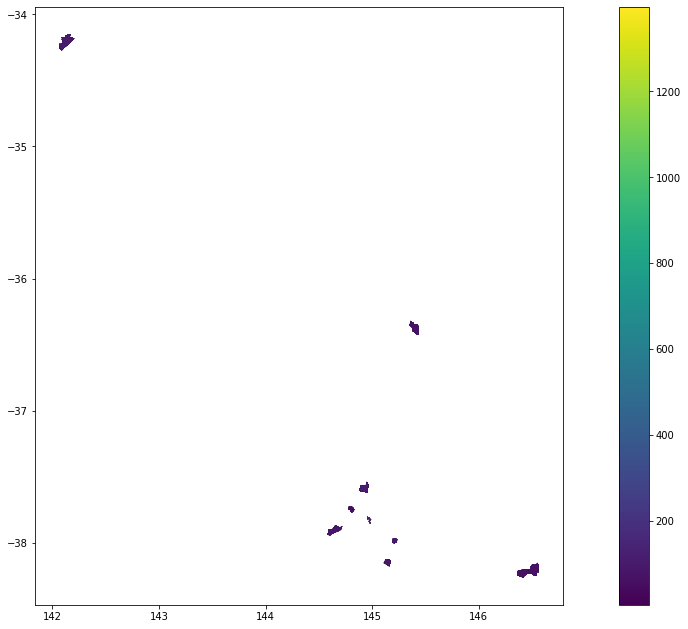

In [ ]:
# set figure size
figsize = (20, 11)

# visualise the area with top 10 highest crime records
df_top_10_map = df_top_10_map[df_top_10_map['Incidents Recorded'] > 1]
df_top_10_map.plot('Incidents Recorded', legend=True, figsize=figsize);

### Crime in Map visualisation

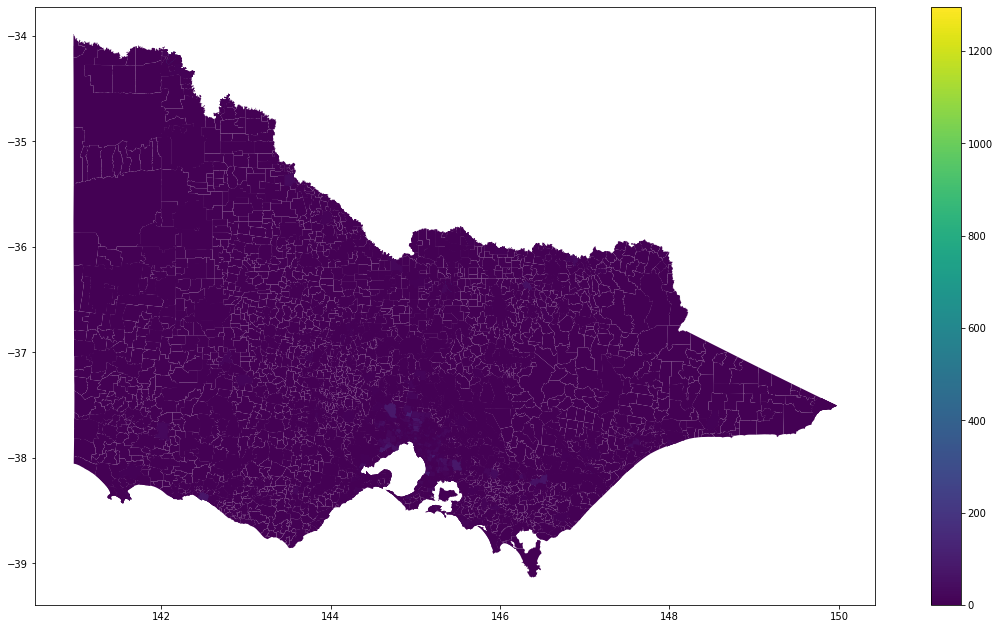

In [ ]:
# filter crime in 2022
df_2022 = df_loc.join(df_crime[df_crime['Year'] == 2022].set_index('id_loc'), on='id')
df_2022 = df_2022.drop(['id'], axis =1)

# fill the nulls
df_2022[df_2022['Year'].isnull()]
df_2022['Year'].fillna(0, inplace=True)
df_2022['Offence Subdivision'].fillna(0, inplace=True)
df_2022['Incidents Recorded'].fillna(0, inplace=True)

# visualise in map 
df_2022.plot('Incidents Recorded', legend=True, figsize=figsize);

### crime trend in top 10 suburb

In [ ]:
# drop geometry column from top 10 area
df_top_10_map_export = df_top_10_map.drop(['geometry', 'latitude', 'longitude'], axis =1)

# change type of Year
df_top_10_map_export['Year'] = df_top_10_map_export['Year'].astype(int)
df_top_10_map_export.head()

,LOC_NAME,postcode,Year,Local Government Area,Offence Subdivision,Incidents Recorded
686,Craigieburn,3064,2013,Hume,Assault and related offences,264.0
686,Craigieburn,3064,2013,Hume,Dangerous and negligent acts endangering people,15.0
686,Craigieburn,3064,2013,Hume,Other crimes against the person,46.0
686,Craigieburn,3064,2013,Hume,Robbery,15.0
686,Craigieburn,3064,2013,Hume,"Stalking, harassment and threatening behaviour",52.0


#### visualisation of all crime records (sum of all type)

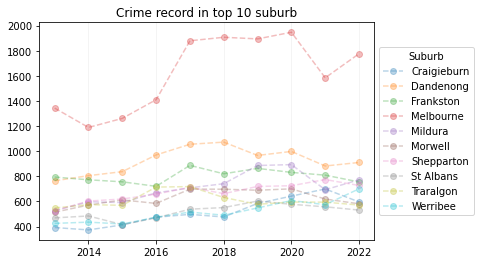

In [ ]:
# group the data bsed on year and location
df_type_year_top_10 = df_top_10_map_export.groupby(['Year', 'LOC_NAME'])['Incidents Recorded'].sum()
df_type_year_top_10 = df_type_year_top_10.rename_axis(['Year', 'LOC_NAME']).reset_index()

# visualise the trend of crime in each area
for t in df_type_year_top_10['LOC_NAME'].unique():
  plt.plot(df_type_year_top_10['Year'].unique(), df_type_year_top_10[df_type_year_top_10['LOC_NAME']== t]['Incidents Recorded'].to_list(), 'o--',  alpha=0.3, label=t)

plt.grid(axis='x', color='0.95')
plt.legend(title='Suburb', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Crime record in top 10 suburb')
plt.show()

#### visualisation of each crime type

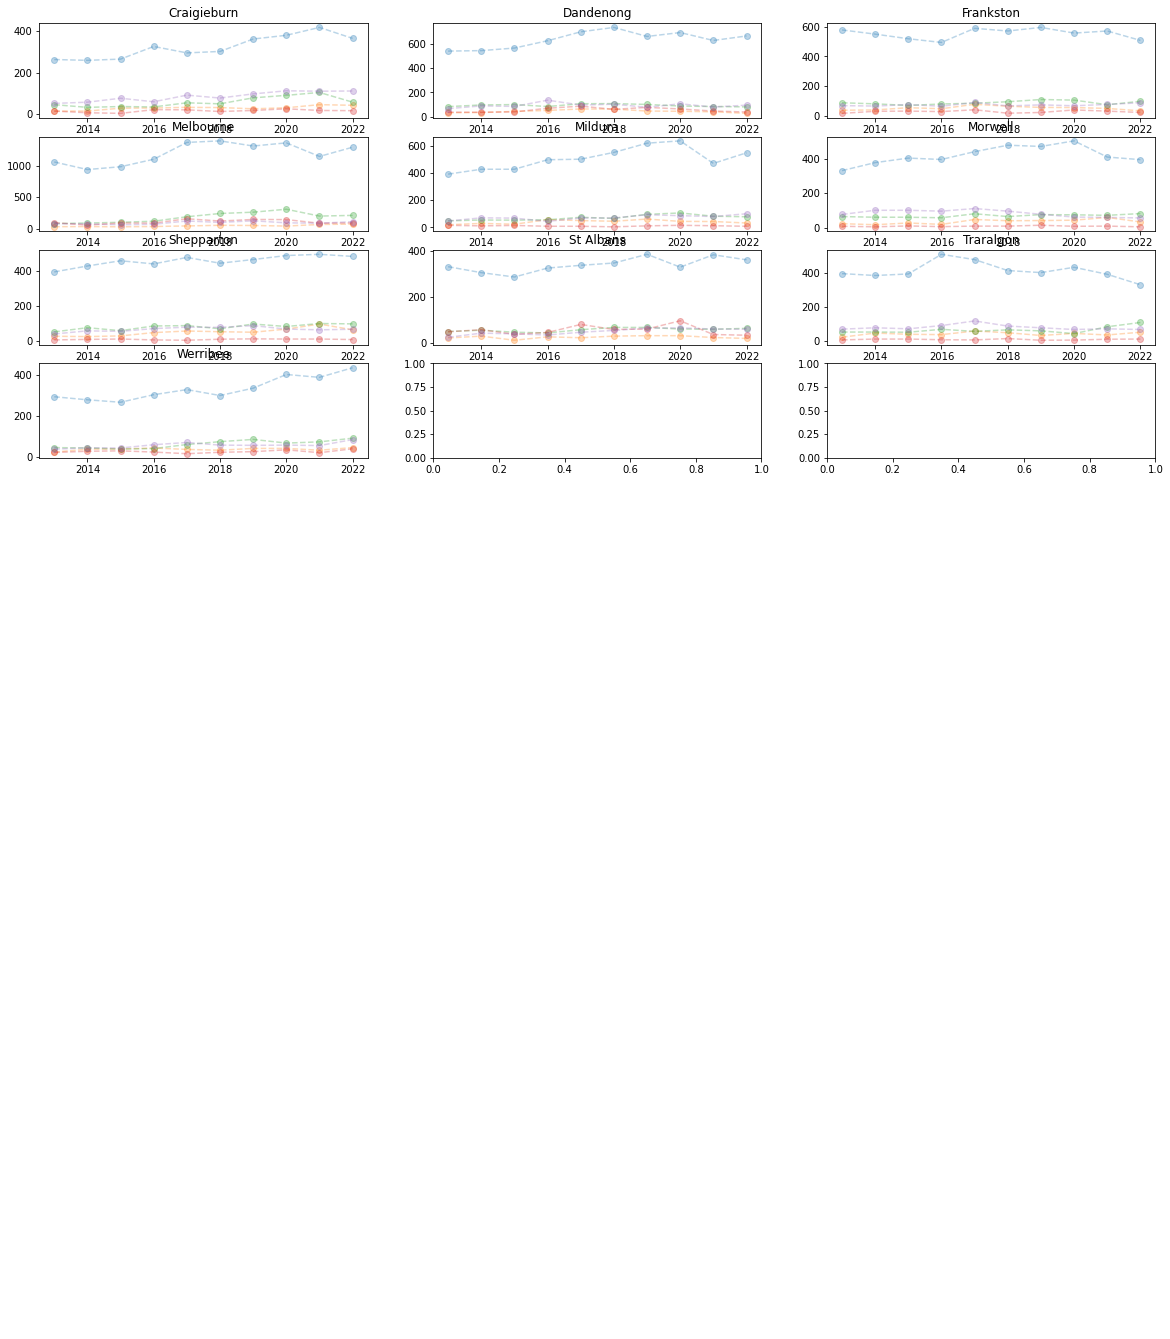

In [ ]:
# set figure setting
fig = plt.figure(figsize=(20,8)) 
axs = fig.subplots(4,3)
row = 0 
col = 0

# plot the crime type trend on each area
for s in df_top_10_map_export['LOC_NAME'].unique():
  for t in df_top_10_map_export['Offence Subdivision'].unique():
    if (col == 3):
      row += 1
      col = 0
    axs[row, col].plot(df_top_10_map_export['Year'].unique(), df_top_10_map_export[(df_top_10_map_export['LOC_NAME']== s) & (df_top_10_map_export['Offence Subdivision']== t)]['Incidents Recorded'].to_list(), 'o--',  alpha=0.3, label=t)
    axs[row, col].set_title(s)
    fig.legend(title='type', loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)
  col+=1


### Crime type trend

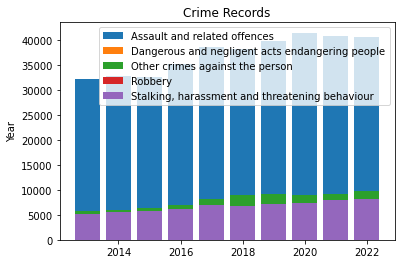

In [ ]:
# group by the type subdivision
df_type_year = df_crime.groupby(['Year', 'Offence Subdivision'])['Incidents Recorded'].sum()
df_type_year = df_type_year.rename_axis(['Year', 'Offence Subdivision']).reset_index()

# figure setting
fig, ax = plt.subplots()

# plot in barplot
for t in df_type_year['Offence Subdivision'].unique():
  ax.bar(df_type_year['Year'].unique(), df_type_year[df_type_year['Offence Subdivision']== t]['Incidents Recorded'].to_list(), label=t)

ax.set_ylabel('Year')
ax.set_title('Crime Records')
ax.legend()
plt.show()

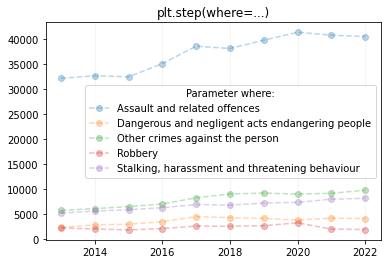

In [ ]:
# plot each type in line graph
for t in df_type_year['Offence Subdivision'].unique():
  plt.plot(df_type_year['Year'].unique(), df_type_year[df_type_year['Offence Subdivision']== t]['Incidents Recorded'].to_list(), 'o--',  alpha=0.3, label=t)
plt.grid(axis='x', color='0.95')
plt.legend(title='Parameter where:')
plt.title('plt.step(where=...)')
plt.show()

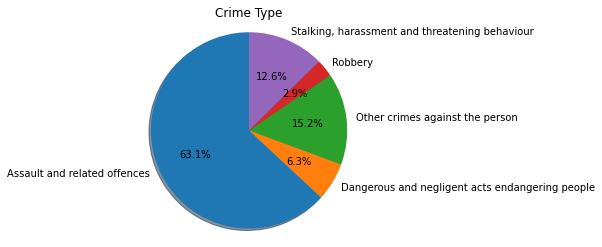

In [ ]:
# figure setting
fig1, ax1 = plt.subplots()

# visualisation in pie chart
ax1.pie(df_type_year[df_type_year['Year'] == 2022]['Incidents Recorded'], labels=df_type_year[df_type_year['Year'] == 2022]['Offence Subdivision'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Crime Type')
plt.show()

#### Conclusion
> Compared to the other defence types, the 'Stalking, harassment and threatening behaviour' records constantly increasing since 2013. Be careful~

> More than half of the crimes that happen is about assault and offences

### Crime records trends in Victoria

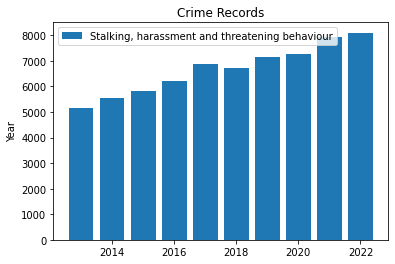

In [ ]:
# figure setting
fig, ax = plt.subplots()

# barplot og stalking, harassment and threatening behaviour crime in Victoria 
ax.bar(df_type_year['Year'].unique(), df_type_year[df_type_year['Offence Subdivision']== 'Stalking, harassment and threatening behaviour']['Incidents Recorded'].to_list(), label='Stalking, harassment and threatening behaviour')
ax.set_ylabel('Year')
ax.set_title('Crime Records')
ax.legend()
plt.show()

In [ ]:
# data detail of 'Stalking, harassment and threatening behaviour' crime
df_type_year[df_type_year['Offence Subdivision']== 'Stalking, harassment and threatening behaviour']['Incidents Recorded'].to_list()

[5141, 5536, 5817, 6218, 6866, 6726, 7156, 7287, 7925, 8102]

### Criminal Incident rate

Criminal incident rate = (Criminal incident count/ERP count) *100,000

In [ ]:
# sum crime records in each year
df_year = df_crime.groupby(['Year'])['Incidents Recorded'].sum()
df_year.head()

Year
2013    47409
2014    48950
2015    49377
2016    53735
2017    60617
Name: Incidents Recorded, dtype: int64

In [ ]:
# make the list of crime rate that happen in each year
li_rate_year = []

# calculate the crime rate in each year
for each in df_year:
  print(each/66743290*100000)
  li_rate_year.append(each/66743290*100000)

71.03185953224661
73.34070585972013
73.98047054617774
80.50996587072649
90.82111475176006
90.72822151859759
94.05889341085823
96.73631611507314
95.70699916051487
96.25686716971849


### Crime trend in past 10 years in Victoria

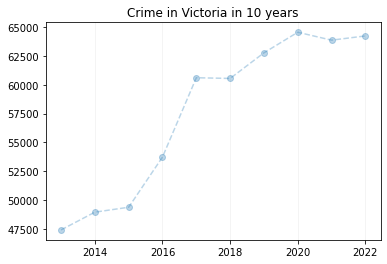

data detail: 
   Year  Incidents Recorded
0  2013               47409
1  2014               48950
2  2015               49377
3  2016               53735
4  2017               60617
5  2018               60555
6  2019               62778
7  2020               64565
8  2021               63878
9  2022               64245


In [ ]:
# group the records by year and type
data_1 = df_type_year.groupby(['Year'])['Incidents Recorded'].sum()
data_1 = data_1.rename_axis(['Year']).reset_index()

# plot the data in line plot
plt.plot(data_1['Year'].unique(), data_1['Incidents Recorded'].to_list(), 'o--',  alpha=0.3, label=t)
plt.grid(axis='x', color='0.95')
plt.title('Crime in Victoria in 10 years')
plt.show()

print('data detail: ')
print(data_1)

### Crime that happen in Victoria each hour, minute, second

In [ ]:
a = against_person_data[against_person_data['Offence Division'] == 'Crimes against the person'].groupby(['Year'])['Incidents Recorded'].sum()
a = a.rename_axis(['Year']).reset_index()

# Crime records increase 
print('Crime records increment in 10 years: ')
print(a['Incidents Recorded'][9] - a['Incidents Recorded'][0])
print()

# rate of increase in 10 years
print('crime rate increase in 10 years: ')
print((a['Incidents Recorded'][9] - a['Incidents Recorded'][0]) / a['Incidents Recorded'][9])
print()

# incident that happen in each second 
print('incident that happen in each second: ')
print(a['Incidents Recorded'][9] / 31536000)
print()

# incident that happen in each minute 
print('incident that happen in each minute: ')
print(a['Incidents Recorded'][9] / 525600)
print()

print('incident that happen in each hour')
print(a['Incidents Recorded'][9] / 8760)

Crime records increment in 10 years: 
16836

crime rate increase in 10 years: 
0.2620593042260098

incident that happen in each second: 
0.0020371955859969557

incident that happen in each minute: 
0.12223173515981735

incident that happen in each hour
7.333904109589041


#### Conclusion


> The crime against other person in Victoria has increased by 26% in the past 10 years

> There are at least 1 people harrased in every minute.

### Crime by age group

In [ ]:
# read dataset of crime with age details
data_age = pd.read_excel('/content/drive/MyDrive/FIT5120 Team TA25 Project Governance Portfolio/System Architecture and Security/Data Governance/Open Dataset/Data_Tables_LGA_Victim_Reports_Year_Ending_March_2022.xlsx', sheet_name='Table 03')
data_age.head()

,Year,Year ending,Local Government Area,Age Group,Victim Reports
0,2022,March,Alpine,00 - 24 years,35
1,2022,March,Alpine,25 - 34 years,25
2,2022,March,Alpine,35 - 44 years,43
3,2022,March,Alpine,45 - 54 years,32
4,2022,March,Alpine,55+ years,41


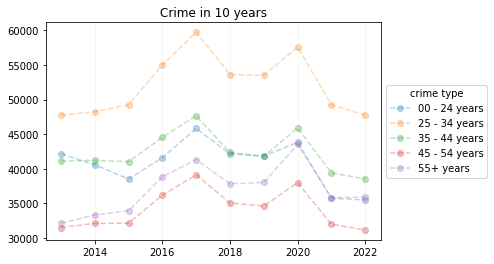

In [ ]:
# group by age range and year
data_age_year = data_age.groupby(['Year', 'Age Group'])['Victim Reports'].sum()
data_age_year = data_age_year.rename_axis(['Year', 'Age Group']).reset_index()

# visualise in line plot
for t in data_age_year['Age Group'].unique():
  plt.plot(data_age_year['Year'].unique(), data_age_year[data_age_year['Age Group']== t]['Victim Reports'].to_list(), 'o--',  alpha=0.3, label=t)
plt.grid(axis='x', color='0.95')
plt.legend(title='crime type', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Crime in 10 years')
plt.show()

In [ ]:
# average of crime reported by each age group 
data_age_avg = data_age.groupby(['Age Group'])['Victim Reports'].sum()
data_age_avg = data_age_avg.rename_axis(['Age Group']).reset_index()
data_age_avg['Victim Reports'] = data_age_avg['Victim Reports'] / 10
data_age_avg

,Age Group,Victim Reports
0,00 - 24 years,40769.3
1,25 - 34 years,52157.9
2,35 - 44 years,42346.6
3,45 - 54 years,34182.8
4,55+ years,37063.7


### Crime by Gender

In [ ]:
# read dataset of crime with age details
data_sex = pd.read_excel('/content/drive/MyDrive/IE/WomanData/Data_Tables_LGA_Victim_Reports_Year_Ending_March_2022.xlsx', sheet_name='Table 04')
data_sex.head()

,Year,Year ending,Local Government Area,Sex,Victim Reports
0,2022,March,Alpine,Females,75
1,2022,March,Alpine,Males,103
2,2022,March,Alpine,Organisations,54
3,2022,March,Alpine,People,179
4,2022,March,Ararat,Females,201


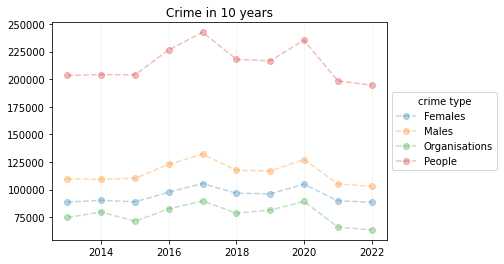

In [ ]:
# group by gender and year
data_sex_year = data_sex.groupby(['Year', 'Sex'])['Victim Reports'].sum()
data_sex_year = data_sex_year.rename_axis(['Year', 'Sex']).reset_index()

# plot in line graph
for t in data_sex_year['Sex'].unique():
  plt.plot(data_sex_year['Year'].unique(), data_sex_year[data_sex_year['Sex']== t]['Victim Reports'].to_list(), 'o--',  alpha=0.3, label=t)
plt.grid(axis='x', color='0.95')
plt.legend(title='crime type', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Crime in 10 years')
plt.show()